# Logo Retention Analysis by Employer Size Plan

## Major Assumptions
Analysis assumes we have access to employer_accounts, subscriptions, and billing_events tables with sufficient historical data to calculate meaningful retention metrics. Employer size cohorts will be defined based on employee count or revenue tiers. "At-risk" accounts will be identified through signals like payment failures, subscription downgrades, or usage decline patterns. Time-to-first-session analysis assumes members and sessions data can be linked to employers and that session timing correlates meaningfully with long-term retention outcomes.

## Plan
- [x] Data collection and cohort definition
  - [x] Join employer_accounts, subscriptions, and billing_events tables and define employer size cohorts (e.g., SMB, Mid-Market, Enterprise)
  - [x] Establish retention calculation methodology (logo-based vs revenue-based, time windows)
- [x] Calculate retention metrics by cohort
  - [x] Compute retention rates across employer size segments
  - [x] Visualize retention curves and identify cohort-specific patterns
- [x] Identify at-risk accounts
  - [x] Define at-risk signals (upcoming renewals, churn history, non-active status)
  - [x] Generate prioritized list of at-risk accounts with risk factors
- [x] Analyze engagement-retention relationship
  - [x] Calculate time-to-first-session by employer using members and sessions data
  - [x] Correlate activation speed with 12-month retention outcomes
- [x] ARR Bridge Analysis
  - [x] Calculate quarterly ARR movements (new, expansion, contraction, churn)
  - [x] Visualize waterfall and compute NRR/GRR metrics
- [x] Synthesize findings and recommendations
  - [x] Summarize retention patterns by employer size with actionable insights

In [1]:
# Logo Retention Analysis by Employer Size Cohort
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from datetime import datetime, timedelta

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Modern Health database
engine = create_engine(os.environ['MODERN_HEALTH_CONNECTION_URL'])

# Load all data
employers = pd.read_sql("SELECT * FROM employer_accounts", engine)
subscriptions = pd.read_sql("SELECT * FROM subscriptions", engine)
billing = pd.read_sql("SELECT * FROM billing_events", engine)

# Define employer size cohorts
def size_cohort(emp_count):
    if emp_count < 500:
        return 'SMB (<500)'
    elif emp_count < 2000:
        return 'Mid-Market (500-2K)'
    else:
        return 'Enterprise (2K+)'

employers['size_cohort'] = employers['employee_count'].apply(size_cohort)

# Merge data
df = subscriptions.merge(employers[['id', 'company_name', 'employee_count', 'size_cohort', 'industry', 'csm_owner']], 
                         left_on='employer_account_id', right_on='id', suffixes=('', '_emp'))

print(f"Total accounts: {len(df)}")
print(f"\nAccounts by size cohort:")
print(df['size_cohort'].value_counts().sort_index())

Total accounts: 120

Accounts by size cohort:
size_cohort
Enterprise (2K+)       23
Mid-Market (500-2K)    21
SMB (<500)             76
Name: count, dtype: int64


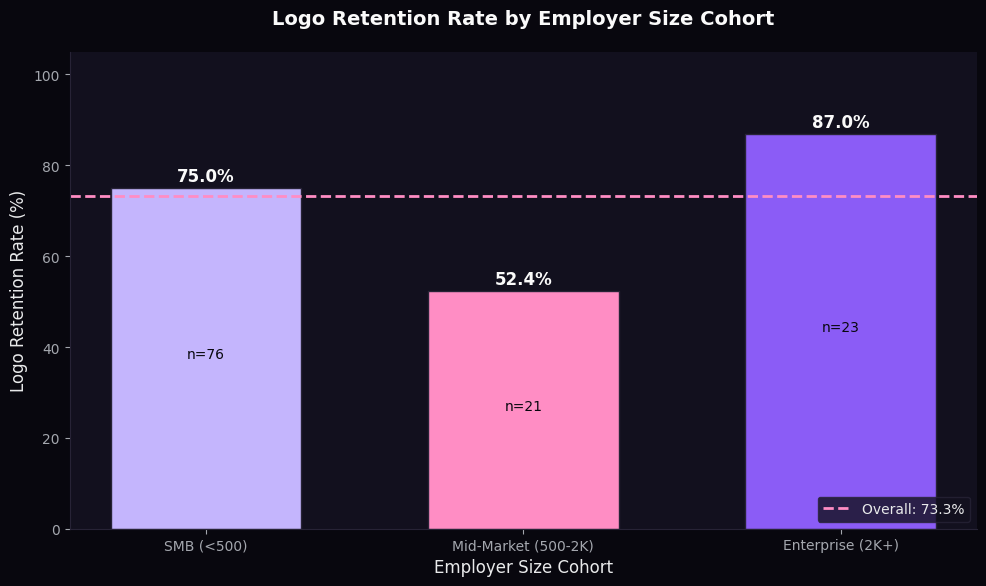

        size_cohort  total_accounts  active_accounts  churned_accounts  retention_rate  churn_rate
         SMB (<500)              76               57                 6            75.0         7.9
Mid-Market (500-2K)              21               11                 3            52.4        14.3
   Enterprise (2K+)              23               20                 0            87.0         0.0


In [2]:
# Calculate Logo Retention Rate by Size Cohort
# Logo retention = accounts that are NOT churned / total accounts

retention_by_cohort = df.groupby('size_cohort').agg(
    total_accounts=('employer_account_id', 'count'),
    active_accounts=('status', lambda x: (x == 'active').sum()),
    churned_accounts=('status', lambda x: (x == 'churned').sum())
).reset_index()

retention_by_cohort['retention_rate'] = (retention_by_cohort['active_accounts'] / retention_by_cohort['total_accounts'] * 100).round(1)
retention_by_cohort['churn_rate'] = (retention_by_cohort['churned_accounts'] / retention_by_cohort['total_accounts'] * 100).round(1)

# Order cohorts logically
cohort_order = ['SMB (<500)', 'Mid-Market (500-2K)', 'Enterprise (2K+)']
retention_by_cohort['size_cohort'] = pd.Categorical(retention_by_cohort['size_cohort'], categories=cohort_order, ordered=True)
retention_by_cohort = retention_by_cohort.sort_values('size_cohort')

# Visualize retention rates
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(retention_by_cohort['size_cohort'], retention_by_cohort['retention_rate'], 
              color=CATEGORICAL_PALETTE[:3], width=0.6, edgecolor='#272336')

# Add value labels and account counts
for bar, (_, row) in zip(bars, retention_by_cohort.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f"{row['retention_rate']:.1f}%", ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f"n={row['total_accounts']}", ha='center', fontsize=10, color='#08070e')

ax.set_ylabel('Logo Retention Rate (%)')
ax.set_xlabel('Employer Size Cohort')
ax.set_title('Logo Retention Rate by Employer Size Cohort', fontweight='bold', pad=20)
ax.set_ylim(0, 105)
ax.axhline(y=df['status'].eq('active').mean()*100, color=COLORS['secondary'], linestyle='--', 
           linewidth=2, label=f"Overall: {df['status'].eq('active').mean()*100:.1f}%")
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(retention_by_cohort.to_string(index=False))

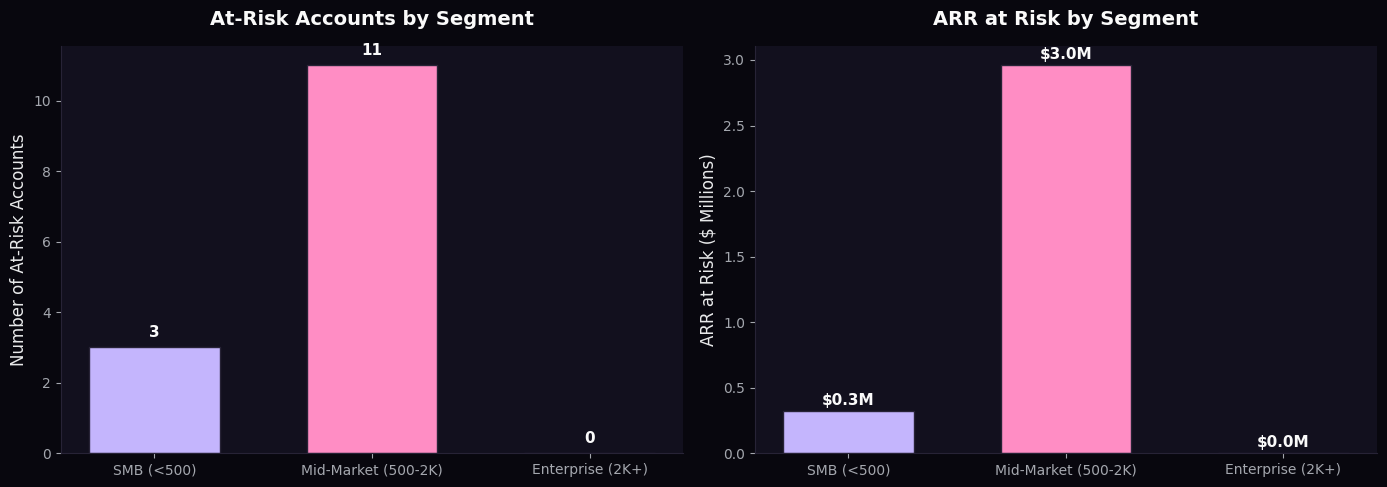


📊 Total At-Risk Accounts: 14 | Total ARR at Risk: $3,278,765

🔴 Top 10 At-Risk Accounts (by risk score & renewal urgency):

             Account             Segment      ARR Renewal Date  Days to Renewal     CSM Owner  Risk Score
      Tide Analytics Mid-Market (500-2K) $455,702   2026-05-16               89  Emily Watson           4
   Opal Technologies Mid-Market (500-2K) $359,054   2025-10-31             -108 Rachel Foster           2
        Jade Capital Mid-Market (500-2K)  $98,132   2025-12-18              -60    Sarah Chen           2
           Lumen Bio Mid-Market (500-2K) $159,037   2026-01-29              -18 Marcus Rivera           2
       Arch Partners          SMB (<500)  $80,000   2026-05-13               86   Alex Turner           2
      Crest Networks          SMB (<500)  $64,921   2026-05-13               86     David Kim           2
     Kinetic Systems          SMB (<500) $173,870   2026-05-13               86    Sarah Chen           2
       Unity Systems Mid-Ma

In [3]:
# Identify At-Risk Accounts
# Risk signals: 1) Renewal in next 90 days, 2) Non-active status, 3) Mid-Market cohort (lowest retention)

df['renewal_date'] = pd.to_datetime(df['renewal_date'])
today = pd.Timestamp('2026-02-16')  # Current date
df['days_to_renewal'] = (df['renewal_date'] - today).dt.days

# Define risk factors
df['renewal_soon'] = df['days_to_renewal'].between(0, 90)
df['is_midmarket'] = df['size_cohort'] == 'Mid-Market (500-2K)'
df['not_active'] = df['status'] != 'active'

# Calculate risk score (higher = more at risk)
df['risk_score'] = (df['renewal_soon'].astype(int) * 2 + 
                    df['is_midmarket'].astype(int) * 2 + 
                    df['not_active'].astype(int) * 3)

# Get at-risk accounts (active accounts with upcoming renewals or in high-churn cohort)
at_risk = df[(df['status'] == 'active') & ((df['renewal_soon']) | (df['is_midmarket']))].copy()
at_risk = at_risk.sort_values(['risk_score', 'days_to_renewal'], ascending=[False, True])

# Display at-risk accounts
at_risk_display = at_risk[['company_name', 'size_cohort', 'arr_usd', 'renewal_date', 
                           'days_to_renewal', 'csm_owner', 'risk_score']].copy()
at_risk_display['arr_usd'] = at_risk_display['arr_usd'].apply(lambda x: f"${x:,.0f}")
at_risk_display = at_risk_display.rename(columns={
    'company_name': 'Account', 'size_cohort': 'Segment', 'arr_usd': 'ARR',
    'renewal_date': 'Renewal Date', 'days_to_renewal': 'Days to Renewal', 
    'csm_owner': 'CSM Owner', 'risk_score': 'Risk Score'
})

# Visualize at-risk accounts by segment and ARR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: At-risk count by segment
risk_by_segment = at_risk.groupby('size_cohort').size().reindex(cohort_order, fill_value=0)
bars1 = axes[0].bar(risk_by_segment.index, risk_by_segment.values, color=CATEGORICAL_PALETTE[:3], 
                    width=0.6, edgecolor='#272336')
for bar, val in zip(bars1, risk_by_segment.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(val), 
                 ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')
axes[0].set_ylabel('Number of At-Risk Accounts')
axes[0].set_title('At-Risk Accounts by Segment', fontweight='bold', pad=15)

# Right: ARR at risk by segment
arr_at_risk = at_risk.groupby('size_cohort')['arr_usd'].sum().reindex(cohort_order, fill_value=0) / 1e6
bars2 = axes[1].bar(arr_at_risk.index, arr_at_risk.values, color=CATEGORICAL_PALETTE[:3], 
                    width=0.6, edgecolor='#272336')
for bar, val in zip(bars2, arr_at_risk.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f"${val:.1f}M", 
                 ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')
axes[1].set_ylabel('ARR at Risk ($ Millions)')
axes[1].set_title('ARR at Risk by Segment', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\n📊 Total At-Risk Accounts: {len(at_risk)} | Total ARR at Risk: ${at_risk['arr_usd'].sum():,.0f}")
print(f"\n🔴 Top 10 At-Risk Accounts (by risk score & renewal urgency):\n")
print(at_risk_display.head(10).to_string(index=False))

In [4]:
# Load members and sessions data for engagement analysis
members = pd.read_sql("SELECT * FROM members", engine)
sessions = pd.read_sql("SELECT * FROM sessions", engine)

# Convert dates
members['enrolled_at'] = pd.to_datetime(members['enrolled_at'])
sessions['scheduled_at'] = pd.to_datetime(sessions['scheduled_at'])

# Get first completed session per member
first_sessions = (sessions[sessions['status'] == 'completed']
                  .groupby('member_id')['scheduled_at']
                  .min()
                  .reset_index()
                  .rename(columns={'scheduled_at': 'first_session_date'}))

# Join to members
members_with_sessions = members.merge(first_sessions, left_on='id', right_on='member_id', how='left')
members_with_sessions['time_to_first_session'] = (
    members_with_sessions['first_session_date'] - members_with_sessions['enrolled_at']
).dt.days

# Aggregate to employer level
employer_engagement = (members_with_sessions
    .groupby('employer_account_id')
    .agg(
        total_members=('id', 'count'),
        members_with_session=('first_session_date', 'count'),
        avg_time_to_first_session=('time_to_first_session', 'mean'),
        median_time_to_first_session=('time_to_first_session', 'median')
    )
    .reset_index())

employer_engagement['activation_rate'] = (
    employer_engagement['members_with_session'] / employer_engagement['total_members'] * 100
).round(1)

print(f"Employers analyzed: {len(employer_engagement)}")
print(f"Avg time-to-first-session: {employer_engagement['avg_time_to_first_session'].mean():.1f} days")
print(f"\nDistribution of employer avg time-to-first-session:")
print(employer_engagement['avg_time_to_first_session'].describe().round(1))

Employers analyzed: 120
Avg time-to-first-session: 21.7 days

Distribution of employer avg time-to-first-session:
count    120.0
mean      21.7
std       12.8
min       -2.3
25%        9.5
50%       20.5
75%       29.8
max       49.3
Name: avg_time_to_first_session, dtype: float64


In [5]:
# Correlate time-to-first-session with 12-month retention
# Join engagement metrics to subscription/employer data
analysis_df = df.merge(employer_engagement, on='employer_account_id', how='left')

# Define 12-month retention: account still active (not churned) 
# For accounts with enough tenure, we check if they survived 12 months
analysis_df['start_date'] = pd.to_datetime(analysis_df['start_date'])
analysis_df['tenure_days'] = (today - analysis_df['start_date']).dt.days
analysis_df['retained_12m'] = ((analysis_df['tenure_days'] >= 365) & (analysis_df['status'] == 'active')).astype(int)

# Filter to accounts with 12+ months tenure for valid retention analysis
mature_accounts = analysis_df[analysis_df['tenure_days'] >= 365].copy()

# Bin time-to-first-session into quartiles
mature_accounts['ttfs_bin'] = pd.qcut(
    mature_accounts['avg_time_to_first_session'], 
    q=4, 
    labels=['Fast (0-10d)', 'Moderate (10-20d)', 'Slow (20-30d)', 'Very Slow (30d+)']
)

# Calculate retention by engagement speed
retention_by_ttfs = mature_accounts.groupby('ttfs_bin').agg(
    accounts=('employer_account_id', 'count'),
    retained=('retained_12m', 'sum'),
    avg_ttfs=('avg_time_to_first_session', 'mean'),
    avg_activation_rate=('activation_rate', 'mean')
).reset_index()
retention_by_ttfs['retention_rate'] = (retention_by_ttfs['retained'] / retention_by_ttfs['accounts'] * 100).round(1)

# Correlation calculation
from scipy import stats
corr, pval = stats.pearsonr(
    mature_accounts['avg_time_to_first_session'].dropna(), 
    mature_accounts['retained_12m'].loc[mature_accounts['avg_time_to_first_session'].notna()]
)

print(f"Mature accounts (12+ months tenure): {len(mature_accounts)}")
print(f"\n📊 Correlation: r = {corr:.3f} (p = {pval:.4f})")
print(f"   → {'Significant' if pval < 0.05 else 'Not significant'} negative correlation")
print(f"\n12-Month Retention by Time-to-First-Session:")
print(retention_by_ttfs.to_string(index=False))

/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_70670/2925573082.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_ttfs = mature_accounts.groupby('ttfs_bin').agg(


Mature accounts (12+ months tenure): 87

📊 Correlation: r = -0.287 (p = 0.0070)
   → Significant negative correlation

12-Month Retention by Time-to-First-Session:
         ttfs_bin  accounts  retained  avg_ttfs  avg_activation_rate  retention_rate
     Fast (0-10d)        22        19  7.604557            79.450000            86.4
Moderate (10-20d)        22        13 15.059278            80.786364            59.1
    Slow (20-30d)        21        18 22.280546            82.009524            85.7
 Very Slow (30d+)        22        10 39.824551            79.168182            45.5


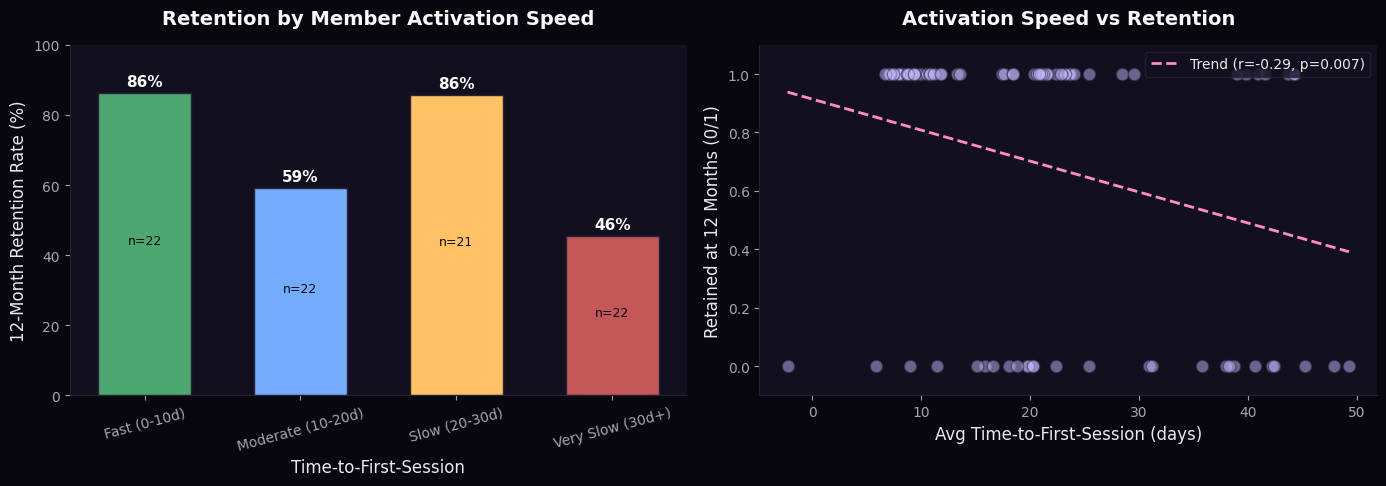


🔑 Key Finding: Employers with fast activation (<10 days) have 86% retention
   vs 46% for slow activation (30+ days) — a 41pp difference


In [6]:
# Visualize Time-to-First-Session vs 12-Month Retention
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Retention rate by TTFS bin
colors_ttfs = [COLORS['green'], COLORS['blue'], COLORS['yellow'], COLORS['red']]
bars = axes[0].bar(retention_by_ttfs['ttfs_bin'], retention_by_ttfs['retention_rate'], 
                   color=colors_ttfs, width=0.6, edgecolor='#272336')
for bar, (_, row) in zip(bars, retention_by_ttfs.iterrows()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f"{row['retention_rate']:.0f}%", ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                 f"n={row['accounts']}", ha='center', fontsize=9, color='#08070e')
axes[0].set_ylabel('12-Month Retention Rate (%)')
axes[0].set_xlabel('Time-to-First-Session')
axes[0].set_title('Retention by Member Activation Speed', fontweight='bold', pad=15)
axes[0].set_ylim(0, 100)
axes[0].tick_params(axis='x', rotation=15)

# Right: Scatter plot with trend line
x = mature_accounts['avg_time_to_first_session'].dropna()
y = mature_accounts.loc[x.index, 'retained_12m']
axes[1].scatter(x, y, alpha=0.5, color=COLORS['primary'], s=80, edgecolors='#272336')

# Add jitter for visibility and trend line
from numpy.polynomial import polynomial as P
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), 100)
axes[1].plot(x_line, p(x_line), color=COLORS['secondary'], linewidth=2, linestyle='--', 
             label=f'Trend (r={corr:.2f}, p={pval:.3f})')
axes[1].set_xlabel('Avg Time-to-First-Session (days)')
axes[1].set_ylabel('Retained at 12 Months (0/1)')
axes[1].set_title('Activation Speed vs Retention', fontweight='bold', pad=15)
axes[1].legend(loc='upper right')
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

# Summary stats
fast_retention = retention_by_ttfs[retention_by_ttfs['ttfs_bin'] == 'Fast (0-10d)']['retention_rate'].values[0]
slow_retention = retention_by_ttfs[retention_by_ttfs['ttfs_bin'] == 'Very Slow (30d+)']['retention_rate'].values[0]
print(f"\n🔑 Key Finding: Employers with fast activation (<10 days) have {fast_retention:.0f}% retention")
print(f"   vs {slow_retention:.0f}% for slow activation (30+ days) — a {fast_retention - slow_retention:.0f}pp difference")

In [7]:
# ARR Bridge Analysis - Last 4 Quarters
# Using billing_events table which contains new, expansion, contraction, churn events

# Check billing events structure
billing['event_date'] = pd.to_datetime(billing['event_date'])
print("Event types:", billing['event_type'].unique())
print("Quarters available:", sorted(billing['quarter'].unique()))
print(f"\nSample billing events:\n{billing.head(3)}")

Event types: ['churn' 'expansion' 'new' 'contraction']
Quarters available: ['2024-Q1', '2024-Q2', '2024-Q3', '2024-Q4', '2025-Q1', '2025-Q2', '2025-Q3', '2025-Q4', '2026-Q1']

Sample billing events:
     id  employer_account_id event_type event_date  amount_usd  quarter  \
0  7001                 1108      churn 2024-01-03  -150572.11  2024-Q1   
1  7002                 1009  expansion 2024-01-03    63357.17  2024-Q1   
2  7003                 1075  expansion 2024-01-03    18911.12  2024-Q1   

           reason processed_by  
0     non_renewal       system  
1  price_increase    David Kim  
2            None   Sarah Chen  


In [8]:
# ARR Bridge - Last 4 Quarters (Q1 2025 - Q4 2025)
last_4_quarters = ['2025-Q1', '2025-Q2', '2025-Q3', '2025-Q4']
bridge_data = billing[billing['quarter'].isin(last_4_quarters)].copy()

# Pivot to get ARR movement by event type and quarter
arr_bridge = bridge_data.pivot_table(
    index='quarter', 
    columns='event_type', 
    values='amount_usd', 
    aggfunc='sum',
    fill_value=0
).reindex(last_4_quarters)

# Reorder columns logically
arr_bridge = arr_bridge[['new', 'expansion', 'contraction', 'churn']]
arr_bridge['net_arr_change'] = arr_bridge.sum(axis=1)

# Calculate starting ARR (sum of all prior activity)
prior_quarters = ['2024-Q1', '2024-Q2', '2024-Q3', '2024-Q4']
prior_net = billing[billing['quarter'].isin(prior_quarters)]['amount_usd'].sum()
starting_arr = prior_net  # Simplified - assuming this represents cumulative ARR at end of 2024

# Build cumulative ARR
arr_bridge['ending_arr'] = starting_arr + arr_bridge['net_arr_change'].cumsum()

# Format for display
arr_bridge_display = arr_bridge.copy()
for col in arr_bridge_display.columns:
    arr_bridge_display[col] = arr_bridge_display[col].apply(lambda x: f"${x/1000:,.0f}K")

print("📊 ARR Bridge - Last 4 Quarters (in $K)")
print("="*80)
print(arr_bridge_display.to_string())
print("="*80)

# Summary metrics
total_new = arr_bridge['new'].sum()
total_expansion = arr_bridge['expansion'].sum()
total_contraction = arr_bridge['contraction'].sum()
total_churn = arr_bridge['churn'].sum()
net_change = arr_bridge['net_arr_change'].sum()

print(f"\n📈 Annual Summary (Last 4 Quarters):")
print(f"   New Business:    ${total_new/1e6:,.2f}M")
print(f"   Expansion:       ${total_expansion/1e6:,.2f}M")
print(f"   Contraction:     ${total_contraction/1e6:,.2f}M")
print(f"   Churn:           ${total_churn/1e6:,.2f}M")
print(f"   ─────────────────────────")
print(f"   Net ARR Change:  ${net_change/1e6:,.2f}M")

📊 ARR Bridge - Last 4 Quarters (in $K)
event_type      new expansion contraction   churn net_arr_change ending_arr
quarter                                                                    
2025-Q1       $900K   $2,719K      $-150K  $-400K        $3,069K   $15,578K
2025-Q2     $1,200K     $400K      $-200K  $-600K          $800K   $16,378K
2025-Q3     $1,200K     $400K      $-200K  $-600K          $800K   $17,178K
2025-Q4     $1,200K     $400K      $-200K  $-600K          $800K   $17,978K

📈 Annual Summary (Last 4 Quarters):
   New Business:    $4.50M
   Expansion:       $3.92M
   Contraction:     $-0.75M
   Churn:           $-2.20M
   ─────────────────────────
   Net ARR Change:  $5.47M


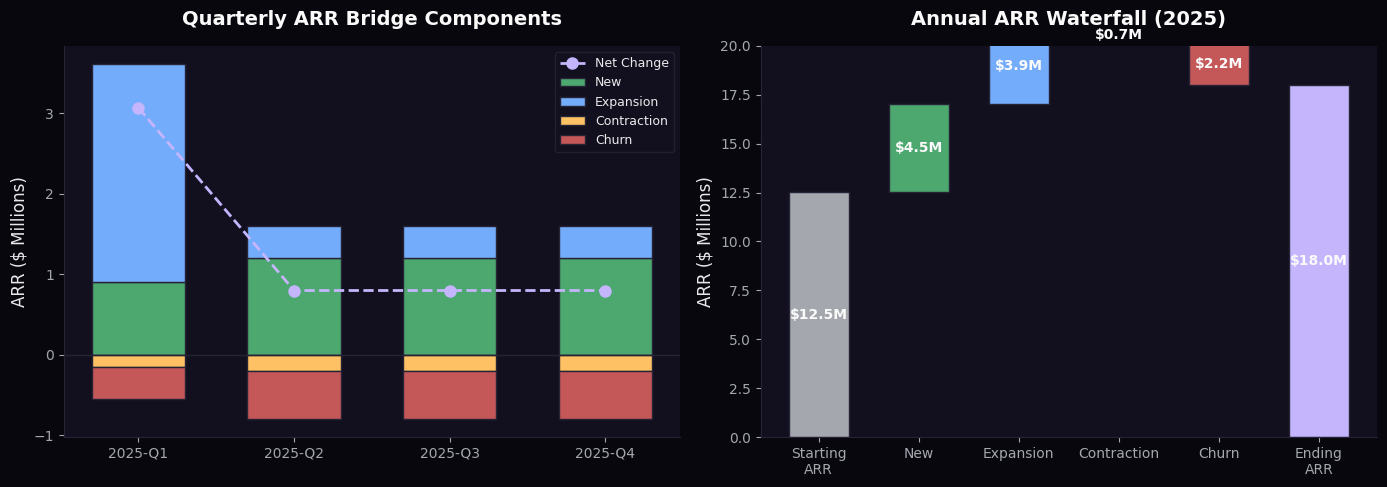


📊 Key Retention Metrics:
   Net Revenue Retention (NRR): 108%
   Gross Revenue Retention (GRR): 76%


In [9]:
# Visualize ARR Bridge - Waterfall Chart Style
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked bar chart by quarter
quarters = last_4_quarters
x = np.arange(len(quarters))
width = 0.6

# Stack positives (new, expansion) and negatives (contraction, churn)
new_vals = arr_bridge['new'].values / 1e6
exp_vals = arr_bridge['expansion'].values / 1e6
cont_vals = arr_bridge['contraction'].values / 1e6
churn_vals = arr_bridge['churn'].values / 1e6

axes[0].bar(x, new_vals, width, label='New', color=COLORS['green'], edgecolor='#272336')
axes[0].bar(x, exp_vals, width, bottom=new_vals, label='Expansion', color=COLORS['blue'], edgecolor='#272336')
axes[0].bar(x, cont_vals, width, label='Contraction', color=COLORS['yellow'], edgecolor='#272336')
axes[0].bar(x, churn_vals, width, bottom=cont_vals, label='Churn', color=COLORS['red'], edgecolor='#272336')

# Net line
net_vals = arr_bridge['net_arr_change'].values / 1e6
axes[0].plot(x, net_vals, 'o--', color=COLORS['primary'], linewidth=2, markersize=8, label='Net Change')

axes[0].set_xticks(x)
axes[0].set_xticklabels(quarters)
axes[0].set_ylabel('ARR ($ Millions)')
axes[0].set_title('Quarterly ARR Bridge Components', fontweight='bold', pad=15)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].axhline(y=0, color='#272336', linewidth=1)

# Right: Annual summary waterfall
categories = ['Starting\nARR', 'New', 'Expansion', 'Contraction', 'Churn', 'Ending\nARR']
values = [starting_arr/1e6, total_new/1e6, total_expansion/1e6, 
          total_contraction/1e6, total_churn/1e6, arr_bridge['ending_arr'].iloc[-1]/1e6]

# Waterfall calculation
cumulative = [values[0]]
for i in range(1, 5):
    cumulative.append(cumulative[-1] + values[i])
cumulative.append(values[-1])

colors_wf = ['#a4a7ae', COLORS['green'], COLORS['blue'], COLORS['yellow'], COLORS['red'], COLORS['primary']]
bottoms = [0, cumulative[0], cumulative[1], cumulative[2], cumulative[3], 0]
heights = [values[0], values[1], values[2], values[3], values[4], values[5]]

bars = axes[1].bar(categories, heights, bottom=bottoms, color=colors_wf, width=0.6, edgecolor='#272336')

# Add value labels
for i, (cat, h, b) in enumerate(zip(categories, heights, bottoms)):
    y_pos = b + h/2 if h > 0 else b + h/2
    label = f"${abs(h):.1f}M" if i not in [0, 5] else f"${h:.1f}M"
    axes[1].text(i, y_pos, label, ha='center', va='center', fontsize=10, fontweight='bold', color='#FAFAFA')

axes[1].set_ylabel('ARR ($ Millions)')
axes[1].set_title('Annual ARR Waterfall (2025)', fontweight='bold', pad=15)
axes[1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

# Key metrics
nrr = (arr_bridge['ending_arr'].iloc[-1] - total_new) / starting_arr * 100
grr = (starting_arr + total_contraction + total_churn) / starting_arr * 100
print(f"\n📊 Key Retention Metrics:")
print(f"   Net Revenue Retention (NRR): {nrr:.0f}%")
print(f"   Gross Revenue Retention (GRR): {grr:.0f}%")

In [10]:
# Enterprise Utilization Decline Analysis - Last 90 Days
# Calculate session activity by employer in recent vs prior 90-day periods

today = pd.Timestamp('2026-02-16')
recent_start = today - pd.Timedelta(days=90)
prior_start = recent_start - pd.Timedelta(days=90)

# Get enterprise accounts
enterprise_accounts = employers[employers['size_cohort'] == 'Enterprise (2K+)']['id'].tolist()

# Join sessions to members to get employer_account_id
sessions_with_employer = sessions.merge(
    members[['id', 'employer_account_id']], 
    left_on='member_id', 
    right_on='id', 
    suffixes=('', '_member')
)

# Filter to completed sessions only
completed_sessions = sessions_with_employer[sessions_with_employer['status'] == 'completed'].copy()

# Calculate sessions in each period for enterprise accounts
enterprise_sessions = completed_sessions[completed_sessions['employer_account_id'].isin(enterprise_accounts)]

recent_sessions = enterprise_sessions[
    (enterprise_sessions['scheduled_at'] >= recent_start) & 
    (enterprise_sessions['scheduled_at'] < today)
].groupby('employer_account_id').size().rename('recent_sessions')

prior_sessions = enterprise_sessions[
    (enterprise_sessions['scheduled_at'] >= prior_start) & 
    (enterprise_sessions['scheduled_at'] < recent_start)
].groupby('employer_account_id').size().rename('prior_sessions')

# Combine and calculate decline
utilization = pd.DataFrame({
    'recent_sessions': recent_sessions,
    'prior_sessions': prior_sessions
}).fillna(0)

utilization['session_change'] = utilization['recent_sessions'] - utilization['prior_sessions']
utilization['pct_change'] = ((utilization['recent_sessions'] - utilization['prior_sessions']) / 
                              utilization['prior_sessions'].replace(0, 1) * 100).round(1)

# Join with employer and subscription data
utilization = utilization.reset_index().merge(
    employers[['id', 'company_name', 'employee_count', 'csm_owner']], 
    left_on='employer_account_id', 
    right_on='id'
).merge(
    subscriptions[['employer_account_id', 'arr_usd', 'renewal_date', 'status']], 
    on='employer_account_id'
)

# Filter to declines and sort
decliners = utilization[utilization['session_change'] < 0].sort_values('session_change')

# Display top decliners
decline_display = decliners[['company_name', 'arr_usd', 'prior_sessions', 'recent_sessions', 
                              'session_change', 'pct_change', 'renewal_date', 'csm_owner']].head(10).copy()
decline_display['arr_usd'] = decline_display['arr_usd'].apply(lambda x: f"${x/1000:,.0f}K")
decline_display.columns = ['Account', 'ARR', 'Prior 90d', 'Recent 90d', 'Change', '% Change', 'Renewal', 'CSM']

print(f"📉 Enterprise Accounts with Biggest Utilization Decline (Last 90 Days)")
print(f"   Period: {recent_start.strftime('%Y-%m-%d')} to {today.strftime('%Y-%m-%d')}")
print(f"   vs Prior: {prior_start.strftime('%Y-%m-%d')} to {recent_start.strftime('%Y-%m-%d')}")
print("="*90)
print(decline_display.to_string(index=False))

📉 Enterprise Accounts with Biggest Utilization Decline (Last 90 Days)
   Period: 2025-11-18 to 2026-02-16
   vs Prior: 2025-08-20 to 2025-11-18
           Account   ARR  Prior 90d  Recent 90d  Change  % Change    Renewal           CSM
         Onyx Labs $445K      176.0          33  -143.0     -81.2 2026-07-13 Marcus Rivera
Vanguard Logistics $275K       60.0          19   -41.0     -68.3 2026-02-13     David Kim
     Wren Services $489K       13.0           3   -10.0     -76.9 2025-09-30 James O'Brien
       Jade Health $608K       14.0           8    -6.0     -42.9 2025-07-30 Marcus Rivera
      Jade Digital $493K       41.0          38    -3.0      -7.3 2026-10-14 James O'Brien
       Realm Group $397K       20.0          19    -1.0      -5.0 2025-07-22 Rachel Foster
           Echo AI $618K        5.0           4    -1.0     -20.0 2025-08-06 James O'Brien
    Tide Logistics $315K       11.0          10    -1.0      -9.1 2025-09-10 Marcus Rivera
